In [72]:
import numpy as np
import pandas as pd
import pymannkendall as mk
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import statsmodels.api as sm
import xarray as xr
import scipy.stats as sstats
from cmcrameri import cm
import cartopy.crs as ccrs
from cartopy.io import shapereader
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import count
import itertools
import rioxarray
from shapely.geometry import mapping
import geopandas as gpd
import cmaps

In [15]:
ctr_basin_sph0 = gpd.read_file("grdc_connecticut/subregions.geojson").iloc[[512]]      # CT river basin shapefile
ctr_basin_sph1 = ctr_basin_sph0.reset_index()

In [19]:
glofas = xr.open_dataset('glofas_ct_river_basin.grib', engine='cfgrib')
#ds2 = ds.sel(time=slice("2000-01-01", "2020-01-01"))
#ds2 = ds2.sel(longitude=dss2.geo_x+360, latitude=dss2.geo_y, method='nearest')

glofas['longitude'] = glofas['longitude'] - 360.0

glofas.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
glofas.rio.write_crs("epsg:4326", inplace=True)
#Africa_Shape = gpd.read_file('grdc_connecticut/subregions.geojson', crs="epsg:4326")

#clipped = MSWEP_monthly2.rio.clip(Africa_Shape.geometry.apply(mapping), Africa_Shape.crs, drop=False)
glofas = glofas.rio.clip(ctr_basin_sph1.geometry.apply(mapping), crs="epsg:4326", drop=False)

In [17]:
clipped_glofas

<xarray.Dataset>
Dimensions:      (latitude: 46, longitude: 26, time: 15341)
Coordinates:
  * latitude     (latitude) float64 45.5 45.4 45.3 45.2 ... 41.3 41.2 41.1 41.0
  * longitude    (longitude) float64 -73.5 -73.4 -73.3 ... -71.2 -71.1 -71.0
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
    step         timedelta64[ns] ...
    surface      float64 ...
    valid_time   (time) datetime64[ns] ...
    spatial_ref  int32 0
Data variables:
    dis24        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-15T23:34 GRIB to CDM+CF via cfgrib-0.9.9...

In [58]:
notnull = pd.notnull(glofas.dis24[0])
glofas.dis24[0].where(notnull)

<xarray.DataArray 'dis24' (latitude: 46, longitude: 26)>
array([[4.1163560e+03, 2.5786133e+00, 9.7309082e+01, ..., 5.1757812e-01,
        6.6406250e-01, 6.0937500e-01],
       [4.1194932e+03, 2.9609375e+00, 9.2951660e+01, ..., 1.0390625e+00,
        4.6142578e-01, 4.0673828e-01],
       [1.5859375e+00, 2.2260742e+00, 9.2375488e+01, ..., 1.3041992e+00,
        7.2607422e-01, 4.1406250e-01],
       ...,
       [1.5229492e+00, 1.3989258e+00, 5.4111328e+00, ...,           nan,
                  nan,           nan],
       [2.5717773e+00, 3.5166016e+00, 7.5317383e+00, ...,           nan,
                  nan,           nan],
       [3.7187500e+00, 4.6640625e+00, 4.1411133e+00, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
    time        datetime64[ns] 1979-01-01
    step        timedelta64[ns] 1 days
    surface     float64 0.0
  * latitude    (latitude) float64 45.5 45.4 45.3 45.2 ... 41.3 41.2 41.1 41.0
  * longitude   (longitude) float64 286.5 286.6 286.7 ... 288.8 288.9 289.0
    valid_time  datetime64[ns] 1979-01-02
Attributes:
    GRIB_paramId:                             240024
    GRIB_dataType:                            sfo
    GRIB_numberOfPoints:                      1196
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  26
    GRIB_Ny:                                  46
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           dis24
    GRIB_gridDefinitionDescription:           Latitude/longitude 
    GRIB_iDirectionIncrementInDegrees:        0.1
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.1
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   45.5
    GRIB_latitudeOfLastGridPointInDegrees:    41.0
    GRIB_longitudeOfFirstGridPointInDegrees:  286.5
    GRIB_longitudeOfLastGridPointInDegrees:   289.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Mean discharge in the last 24 h...
    GRIB_shortName:                           dis24
    GRIB_units:                               m**3 s**-1
    long_name:                                Mean discharge in the last 24 h...
    units:                                    m**3 s**-1
    standard_name:                            unknown

In [18]:
# extreme river discharge

glofas_extreme = clipped_glofas.groupby("time.year").quantile(0.99)
glofas_extreme

C:\Users\panmits86\Anaconda3\envs\unidata\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<xarray.Dataset>
Dimensions:    (latitude: 46, longitude: 26, year: 42)
Coordinates:
  * latitude   (latitude) float64 45.5 45.4 45.3 45.2 ... 41.3 41.2 41.1 41.0
  * longitude  (longitude) float64 -73.5 -73.4 -73.3 -73.2 ... -71.2 -71.1 -71.0
    quantile   float64 0.99
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020
Data variables:
    dis24      (year, latitude, longitude) float64 nan nan nan ... nan nan nan

In [20]:
# do the same but now seasonaly

glofas_winter = glofas.sel(time=glofas.time.dt.season=="DJF")
glofas_winter_extreme = glofas_winter.groupby("time.year").quantile(0.99)

glofas_spring = glofas.sel(time=glofas.time.dt.season=="MAM")
glofas_spring_extreme = glofas_spring.groupby("time.year").quantile(0.99)

glofas_summer = glofas.sel(time=glofas.time.dt.season=="JJA")
glofas_summer_extreme = glofas_summer.groupby("time.year").quantile(0.99)

glofas_fall = glofas.sel(time=glofas.time.dt.season=="SON")
glofas_fall_extreme = glofas_fall.groupby("time.year").quantile(0.99)

C:\Users\panmits86\Anaconda3\envs\unidata\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\panmits86\Anaconda3\envs\unidata\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\panmits86\Anaconda3\envs\unidata\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\panmits86\Anaconda3\envs\unidata\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [21]:
# define a function to compute a linear trend of a timeseries
def linear_trend(x):
    pf = np.polyfit(x.year, x, 1)
    # need to return an xr.DataArray for groupby
    return xr.DataArray(pf[0]*10)

# stack lat and lon into a single dimension called allpoints
stacked = glofas_winter_extreme.dis24.stack(allpoints=['latitude','longitude'])
stacked = stacked.fillna(0)
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked_winter = trend.unstack('allpoints')
trend_unstacked_winter = trend_unstacked_winter.rename({'dim_0': 'trend', 'allpoints_level_0': 'lat','allpoints_level_1': 'lon'})
trend_unstacked_winter = trend_unstacked_winter.where(trend_unstacked_winter[0] != 0.)

stacked = glofas_spring_extreme.dis24.stack(allpoints=['latitude','longitude'])
stacked = stacked.fillna(0)
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked_spring = trend.unstack('allpoints')
trend_unstacked_spring = trend_unstacked_spring.rename({'dim_0': 'trend', 'allpoints_level_0': 'lat','allpoints_level_1': 'lon'})
trend_unstacked_spring = trend_unstacked_spring.where(trend_unstacked_spring[0] != 0.)

stacked = glofas_summer_extreme.dis24.stack(allpoints=['latitude','longitude'])
stacked = stacked.fillna(0)
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked_summer = trend.unstack('allpoints')
trend_unstacked_summer = trend_unstacked_summer.rename({'dim_0': 'trend', 'allpoints_level_0': 'lat','allpoints_level_1': 'lon'})
trend_unstacked_summer = trend_unstacked_summer.where(trend_unstacked_summer[0] != 0.)

stacked = glofas_fall_extreme.dis24.stack(allpoints=['latitude','longitude'])
stacked = stacked.fillna(0)
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked_fall = trend.unstack('allpoints')
trend_unstacked_fall = trend_unstacked_fall.rename({'dim_0': 'trend', 'allpoints_level_0': 'lat','allpoints_level_1': 'lon'})
trend_unstacked_fall = trend_unstacked_fall.where(trend_unstacked_fall[0] != 0.)

In [22]:
trend_unstacked_spring.min(), trend_unstacked_summer.max()

(<xarray.DataArray ()>
 array(-160.93254886),
 <xarray.DataArray ()>
 array(0.67884171))

In [20]:
trend_unstacked_spring

<xarray.DataArray (trend: 1, lat: 46, lon: 26)>
array([[[ 4.13507130e-02, -4.86572664e-02,  2.35942294e-01, ...,
                     nan,             nan,             nan],
        [ 3.84228450e-02, -1.16728769e-01,  3.89339676e-01, ...,
                     nan,             nan,             nan],
        [ 8.72469509e-04,  1.73881259e-02,  3.74902712e-01, ...,
                     nan,             nan,             nan],
        ...,
        [ 7.29412363e-01,  1.36971922e+00,  5.28201756e-01, ...,
          1.81165783e+00,  1.10326754e+00,  6.98180505e-01],
        [ 2.39473136e+02,  1.75418947e+00,  6.62731911e-01, ...,
          1.47513595e+00,  7.04060175e-01,  1.00496323e+00],
        [ 2.39162982e+02,  1.21183092e+00,  1.78329210e+00, ...,
          9.84028129e-01,  1.31033790e+00,  1.52640772e+00]]])
Coordinates:
  * lat      (lat) float64 41.0 41.1 41.2 41.3 41.4 ... 45.1 45.2 45.3 45.4 45.5
  * lon      (lon) float64 286.5 286.6 286.7 286.8 ... 288.7 288.8 288.9 289.0
Dimensions without coordinates: trend

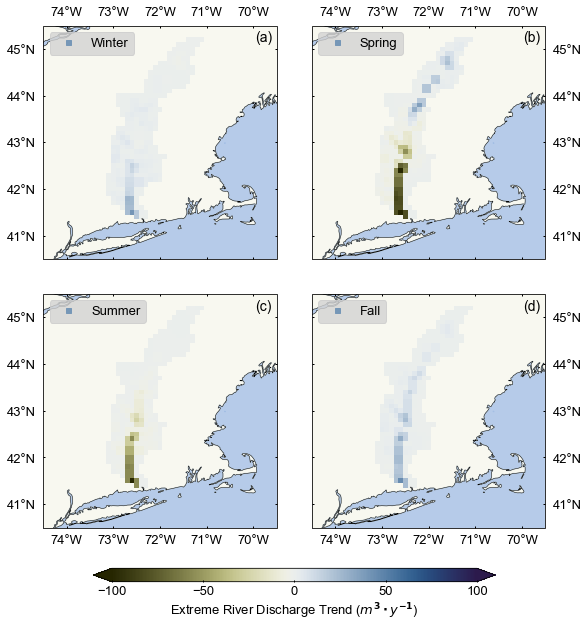

In [45]:
fig, ax_lst = plt.subplots(2, 2, figsize=(9,12.5), subplot_kw=dict(projection=ccrs.PlateCarree()), 
                           gridspec_kw={'hspace': 0.0, 'wspace': 0.15})

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 13

def label_subplots(ax_lst, *, upper_case=False,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), ('('+chr(j)+')' for j in count(start_ord))):
        ax.annotate(lab, (1., 1.),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='regular')


label_subplots(ax_lst, upper_case=False)


def custom_div_cmap(numcolors=25, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap


cmap = cm.broc
cmap = cmap.reversed()
#cmap = cm.batlow

#bounds = np.array([-5.,-4.,-3.,-2.,-1.,0.,1.,2.,3.,4.,5.])
min_lon = -74.5
max_lon = -69.5
min_lat = 40.5
max_lat = 45.5

lon_ticks = [-74, -73, -72, -71, -70]
lat_ticks = [41, 42, 43, 44, 45]

#cmap = cmaps.GMT_drywet

blevels = [-150.,-100.,-50.,0.,50.,100.,150]
ticks = np.array([-150.,-100.,50.,0.,100.,50.,150.])
N = len(blevels)-1
#cmap2 = custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
#cmap2 = custom_div_cmap(N, mincol=cmap(0.9), midcol=cmap(0.5) ,maxcol=cmap(0.1))
cmap2 = custom_div_cmap(N, mincol=cmap(1.), midcol=cmap(0.5) ,maxcol=cmap(0.))
cmap2.set_over('1.') # light gray

from matplotlib.colors import BoundaryNorm
bnorm = BoundaryNorm(blevels, ncolors=N, clip=False)


# Figure 1

ax_lst[0,0].set_extent([-74.5, -69.5, 40.5, 45.5])
ax_lst[0,0].xaxis.set_major_formatter(LongitudeFormatter())
ax_lst[0,0].yaxis.set_major_formatter(LatitudeFormatter())

#lon_ticks = np.arange(min_lon, max_lon, 1)
#lat_ticks = np.arange(min_lat, max_lat, 1)

ax_lst[0,0].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_lst[0,0].set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax_lst[0,0].xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax_lst[0,0].yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax_lst[0,0].tick_params(labelleft=True,labelbottom=False,labeltop=True,labelright=False)  

ax_lst[0,0].add_feature(cfeature.LAND.with_scale('10m'), color='white', alpha=0.4)

ax_lst[0,0].coastlines(resolution='10m',linewidth=0.5)
#ax_lst[0,0].add_feature(cfeature.STATES.with_scale('10m'),linewidth=0.5,alpha=0.8)
ax_lst[0,0].add_feature(cfeature.OCEAN, alpha=0.7)
ax_lst[0,0].add_feature(cfeature.LAND, alpha=0.4)

lon, lat= np.meshgrid(trend_unstacked_winter.lon,trend_unstacked_winter.lat)

#notnull = pd.notnull(ds_unweighted['dis24'][0])  .where(notnull)
cs2 = ax_lst[0,0].pcolormesh(lon, lat, trend_unstacked_winter[0], vmin=-100.,vmax=100., cmap=cmap)

#.where(notnull)
cax,kw = mpl.colorbar.make_axes(ax_lst,location='bottom',pad=0.06,aspect=30, shrink=0.8)
cmap.set_over(cmap(1.0))
out=fig.colorbar(cs2, cax=cax, ticks=blevels,extend='both',**kw)
out.set_label('Extreme River Discharge Trend ($m^3 \cdot y^{-1}$)')
out.ax.tick_params(direction='in',size=2., width=1)


precipitation = Line2D([0], [0], marker='s', color='white', linestyle="", label='Winter',
                          markerfacecolor=cmap(0.7),markeredgecolor=cmap(0.7), markersize=5)
                  
ax_lst[0,0].legend(handles=[precipitation], loc='upper left',fontsize=13, facecolor='lightgrey')


# Figure 2


ax_lst[0,1].set_extent([-74.5, -69.5, 40.5, 45.5])
ax_lst[0,1].xaxis.set_major_formatter(LongitudeFormatter())
ax_lst[0,1].yaxis.set_major_formatter(LatitudeFormatter())

#lon_ticks = np.arange(min_lon, max_lon, 1)
#lat_ticks = np.arange(min_lat, max_lat, 1)

ax_lst[0,1].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_lst[0,1].set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax_lst[0,1].xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax_lst[0,1].yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax_lst[0,1].tick_params(labelleft=False,labelbottom=False,labeltop=True,labelright=True)  

ax_lst[0,1].add_feature(cfeature.LAND.with_scale('10m'), color='white', alpha=0.4)

ax_lst[0,1].coastlines(resolution='10m',linewidth=0.5)
ax_lst[0,1].add_feature(cfeature.OCEAN, alpha=0.7)
ax_lst[0,1].add_feature(cfeature.LAND, alpha=0.4)

lon, lat= np.meshgrid(trend_unstacked_spring.lon,trend_unstacked_spring.lat)

cs2 = ax_lst[0,1].pcolormesh(lon, lat, trend_unstacked_spring[0], vmin=-100.,vmax=100., 
                             cmap=cmap)

precipitation = Line2D([0], [0], marker='s', color='white', linestyle="", label='Spring',
                          markerfacecolor=cmap(0.7),markeredgecolor=cmap(0.7), markersize=5)
                  
ax_lst[0,1].legend(handles=[precipitation], loc='upper left',fontsize=13, facecolor='lightgrey')


# Figure 3

ax_lst[1,0].set_extent([-74.5, -69.5, 40.5, 45.5])
ax_lst[1,0].xaxis.set_major_formatter(LongitudeFormatter())
ax_lst[1,0].yaxis.set_major_formatter(LatitudeFormatter())

#lon_ticks = np.arange(min_lon, max_lon, 1)
#lat_ticks = np.arange(min_lat, max_lat, 1)

ax_lst[1,0].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_lst[1,0].set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax_lst[1,0].xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax_lst[1,0].yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax_lst[1,0].tick_params(labelleft=True,labelbottom=True,labeltop=False,labelright=False)  

ax_lst[1,0].add_feature(cfeature.LAND.with_scale('10m'), color='white', alpha=0.4)

ax_lst[1,0].coastlines(resolution='10m',linewidth=0.5)
ax_lst[1,0].add_feature(cfeature.OCEAN, alpha=0.7)
ax_lst[1,0].add_feature(cfeature.LAND, alpha=0.4)

lon, lat= np.meshgrid(trend_unstacked_summer.lon,trend_unstacked_summer.lat)

cs2 = ax_lst[1,0].pcolormesh(lon, lat, trend_unstacked_summer[0], vmin=-100.,vmax=100., 
                             cmap=cmap)

precipitation = Line2D([0], [0], marker='s', color='white', linestyle="", label='Summer',
                          markerfacecolor=cmap(0.7),markeredgecolor=cmap(0.7), markersize=5)
                  
ax_lst[1,0].legend(handles=[precipitation], loc='upper left',fontsize=13, facecolor='lightgrey')


# Figure 4

ax_lst[1,1].set_extent([-74.5, -69.5, 40.5, 45.5])
ax_lst[1,1].xaxis.set_major_formatter(LongitudeFormatter())
ax_lst[1,1].yaxis.set_major_formatter(LatitudeFormatter())

#lon_ticks = np.arange(min_lon, max_lon, 1)
#lat_ticks = np.arange(min_lat, max_lat, 1)

ax_lst[1,1].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_lst[1,1].set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax_lst[1,1].xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax_lst[1,1].yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax_lst[1,1].tick_params(labelleft=False,labelbottom=True,labeltop=False,labelright=True)  

ax_lst[1,1].add_feature(cfeature.LAND.with_scale('10m'), color='white', alpha=0.4)

ax_lst[1,1].coastlines(resolution='10m',linewidth=0.5)
ax_lst[1,1].add_feature(cfeature.OCEAN, alpha=0.7)
ax_lst[1,1].add_feature(cfeature.LAND, alpha=0.4)

lon, lat= np.meshgrid(trend_unstacked_fall.lon,trend_unstacked_fall.lat)

cs2 = ax_lst[1,1].pcolormesh(lon, lat, trend_unstacked_fall[0], vmin=-100.,vmax=100., 
                             cmap=cmap)

precipitation = Line2D([0], [0], marker='s', color='white', linestyle="", label='Fall',
                          markerfacecolor=cmap(0.7),markeredgecolor=cmap(0.7), markersize=5)
                  
ax_lst[1,1].legend(handles=[precipitation], loc='upper left',fontsize=13, facecolor='lightgrey')

plt.savefig('seasonal_extreme_rd_allyears.png', format='png', transparent=False, dpi=600, bbox_inches='tight')

<AxesSubplot:ylabel='Count'>

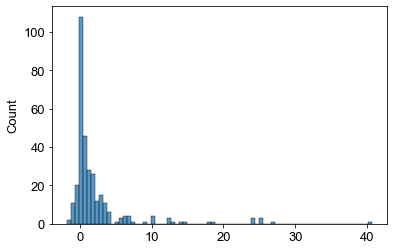

In [36]:
import seaborn as sns
sns.histplot(data=trend_unstacked_winter[0].values.flatten())

In [39]:
trend_unstacked_winter[0].values.flatten().max()

nan

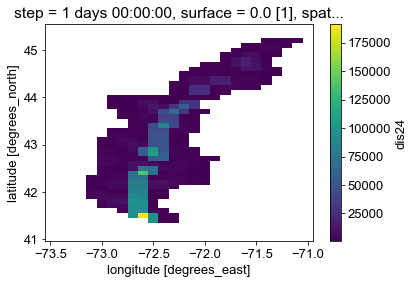

In [46]:
glofas_yearly_sum = glofas.groupby("time.year").sum('time')
glofas_yearly_sum_year = glofas_yearly_sum.mean('year')
glofas_yearly_sum_year = glofas_yearly_sum_year.where(glofas_yearly_sum_year.dis24 != 0.)
glofas_yearly_sum_year.dis24.plot()

In [55]:
glofas_yearly_sum_year

<xarray.Dataset>
Dimensions:      (latitude: 46, longitude: 26)
Coordinates:
  * latitude     (latitude) float64 45.5 45.4 45.3 45.2 ... 41.3 41.2 41.1 41.0
  * longitude    (longitude) float64 -73.5 -73.4 -73.3 ... -71.2 -71.1 -71.0
    step         timedelta64[ns] 1 days
    surface      float64 0.0
    spatial_ref  int32 0
Data variables:
    dis24        (latitude, longitude) float32 nan nan nan nan ... nan nan nan

In [48]:
glofas_yearly_sum_year.dis24.min(), glofas_yearly_sum_year.dis24.max()

(<xarray.DataArray 'dis24' ()>
 array(429.54324341)
 Coordinates:
     step         timedelta64[ns] 1 days
     surface      float64 0.0
     spatial_ref  int32 0,
 <xarray.DataArray 'dis24' ()>
 array(191411.96875)
 Coordinates:
     step         timedelta64[ns] 1 days
     surface      float64 0.0
     spatial_ref  int32 0)

In [50]:
# trend of annual total precipitation
glofas_yearly_sum = glofas.groupby("time.year").sum('time')

# define a function to compute a linear trend of a timeseries
def linear_trend(x):
    pf = np.polyfit(x.year, x, 1)
    # need to return an xr.DataArray for groupby
    return xr.DataArray(pf[0]*10)

# stack lat and lon into a single dimension called allpoints
stacked = glofas_yearly_sum.dis24.stack(allpoints=['latitude','longitude'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')
trend_unstacked = trend_unstacked.rename({'dim_0': 'trend', 'allpoints_level_0': 'lat','allpoints_level_1': 'lon'})
trend_unstacked = trend_unstacked.where(trend_unstacked[0] != 0.)

In [51]:
trend_unstacked.max().values, trend_unstacked.min().values

(array(2089.24302756), array(-10.76425254))

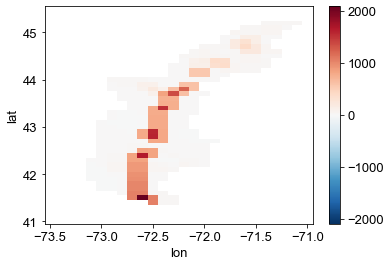

In [52]:
trend_unstacked.plot()

C:\Users\PANMIT~1\AppData\Local\Temp/ipykernel_10384/3717943545.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


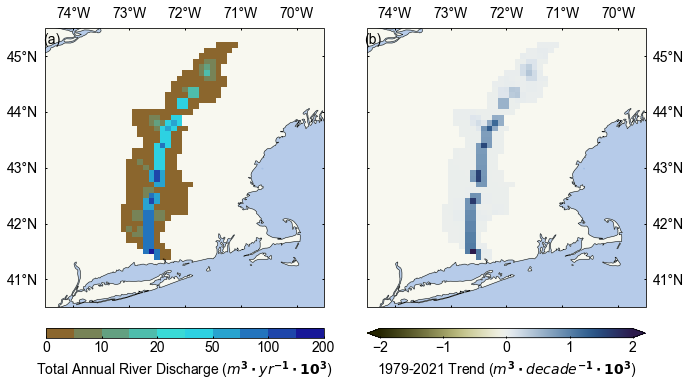

In [75]:
fig, ax_lst = plt.subplots(1, 2,figsize=(11., 6.5), subplot_kw=dict(projection=ccrs.PlateCarree()),
                                                                    gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
fig.tight_layout()

def label_subplots(ax_lst, *, upper_case=False,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), ('('+chr(j)+')' for j in count(start_ord))):
        ax.annotate(lab, (0.07, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='regular')


label_subplots(ax_lst, upper_case=False)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

#cmap = cm.batlow
cmap3 = cm.broc
cmap3 = cmap3.reversed()

def custom_div_cmap(numcolors=25, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap



#cmap=cmaps.cmocean_tempo
#cmap = cm.devon
cmap = cmaps.GMT_drywet

blevels = [0.,5.,10.,15.,20.,25.,50.,75.,100.,150.,200.]
N = len(blevels)-1
#cmap2 = custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
#cmap2 = custom_div_cmap(N, mincol=cmap(0.9), midcol=cmap(0.5) ,maxcol=cmap(0.1))
cmap2 = custom_div_cmap(N, mincol=cmap(0.), midcol=cmap(0.5) ,maxcol=cmap(0.9))
cmap2.set_over('1.') # light gray

from matplotlib.colors import BoundaryNorm
bnorm = BoundaryNorm(blevels, ncolors=N, clip=False)


bounds = np.array([0.,5.,10.,15.,20.,25.,50.,75.,100.,200.])
ticks = np.array([0.,10.,20.,50.,100.,200.])

#bounds = np.array([1000, 1100, 1200, 1300, 1400., 1500.])
bounds2 = np.array([-2.,-1.,0,1.,2.])

lon_ticks = [-74, -73, -72, -71, -70]
lat_ticks = [41, 42, 43, 44, 45]

# Figure 1

ax_lst[0].set_extent([-74.5, -69.5, 40.5, 45.5])
ax_lst[0].xaxis.set_major_formatter(LongitudeFormatter())
ax_lst[0].yaxis.set_major_formatter(LatitudeFormatter())

#lon_ticks = np.arange(min_lon, max_lon, 1)
#lat_ticks = np.arange(min_lat, max_lat, 1)

ax_lst[0].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_lst[0].set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax_lst[0].xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax_lst[0].yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax_lst[0].tick_params(labelleft=True,labelbottom=False,labeltop=True,labelright=False)  

ax_lst[0].add_feature(cfeature.LAND.with_scale('10m'), color='white', alpha=0.4)
#ax_lst[0].add_feature(cfeature.STATES, linewidth=0.4)

ax_lst[0].coastlines(resolution='10m',linewidth=0.5)
#ax_lst[0,0].add_feature(cfeature.STATES.with_scale('10m'),linewidth=0.5,alpha=0.8)
ax_lst[0].add_feature(cfeature.OCEAN, alpha=0.7)
ax_lst[0].add_feature(cfeature.LAND, alpha=0.4)

lon, lat= np.meshgrid(glofas_yearly_sum_year.longitude,glofas_yearly_sum_year.latitude)

cs2 = ax_lst[0].pcolormesh(lon, lat, glofas_yearly_sum_year.dis24/1000, norm=bnorm,
                             cmap=cmap2)
#.where(notnull)
cax,kw = mpl.colorbar.make_axes(ax_lst[0],location='bottom',pad=0.06,aspect=30, shrink=0.95)
out=fig.colorbar(cs2, cax=cax, ticks=ticks,**kw)
out.set_label('Total Annual River Discharge ($m^3 \cdot yr^{-1} \cdot 10^{3}$)')
out.ax.tick_params(direction='in',size=2., width=1)

"""
precipitation = Line2D([0], [0], marker='s', color='white', linestyle="", label='Winter',
                          markerfacecolor=cmap(0.5),markeredgecolor=cmap(0.5), markersize=5)
                  
ax_lst[0].legend(handles=[precipitation], loc='upper left',fontsize=13, facecolor='lightgrey')
"""

# Figure 2

ax_lst[1].set_extent([-74.5, -69.5, 40.5, 45.5])
ax_lst[1].xaxis.set_major_formatter(LongitudeFormatter())
ax_lst[1].yaxis.set_major_formatter(LatitudeFormatter())

#lon_ticks = np.arange(min_lon, max_lon, 1)
#lat_ticks = np.arange(min_lat, max_lat, 1)

ax_lst[1].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_lst[1].set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax_lst[1].xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax_lst[1].yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax_lst[1].tick_params(labelleft=False,labelbottom=False,labeltop=True,labelright=True)  

ax_lst[1].add_feature(cfeature.LAND.with_scale('10m'), color='white', alpha=0.4)

ax_lst[1].coastlines(resolution='10m',linewidth=0.5)
ax_lst[1].add_feature(cfeature.OCEAN, alpha=0.7)
ax_lst[1].add_feature(cfeature.LAND, alpha=0.4)

lon, lat= np.meshgrid(trend_unstacked.lon,trend_unstacked.lat)

cs2 = ax_lst[1].pcolormesh(lon, lat, trend_unstacked[0]/1000, vmin=-2.,vmax=2., 
                             cmap=cmap3)
"""
precipitation = Line2D([0], [0], marker='s', color='white', linestyle="", label='Spring',
                          markerfacecolor=cmap(0.5),markeredgecolor=cmap(0.5), markersize=5)
                  
ax_lst[1].legend(handles=[precipitation], loc='upper left',fontsize=13, facecolor='lightgrey')
"""

cax,kw = mpl.colorbar.make_axes(ax_lst[1],location='bottom',pad=0.06,aspect=30, shrink=0.95)
out=fig.colorbar(cs2, cax=cax, ticks=bounds2,extend='both',**kw)
out.set_label('1979-2021 Trend ($m^3 \cdot decade^{-1} \cdot 10^3$)')
out.ax.tick_params(direction='in',size=2., width=1)

plt.savefig('enve5810_total_annual_rd_allyears.png', format='png', transparent=False, dpi=600, bbox_inches='tight')